**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [ ]:
torch.cuda.set_device(2)

In [ ]:
torch.backends.cudnn.benchmark=True

## Data

In [ ]:
PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [ ]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [ ]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [ ]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [ ]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [ ]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [ ]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [ ]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

## Simple upsample

In [ ]:
f = resnet34
cut,lr_cut = model_meta[f]

In [ ]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [ ]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [ ]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [ ]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [ ]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [ ]:
m_base = get_base()

In [ ]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|█████████████████████████████████████████████████████████████          | 55/64 [00:22<00:03,  2.46it/s, loss=3.21]

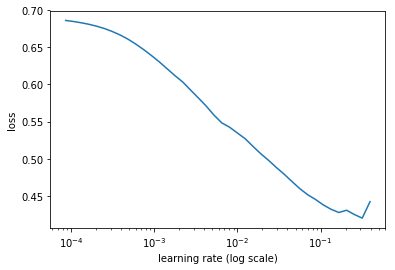

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

  0%|          | 0/64 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.216882   0.133512   0.938017   0.855221  
    1      0.169544   0.115158   0.946518   0.878381       
    2      0.153114   0.099104   0.957748   0.903353       
    3      0.144105   0.093337   0.964404   0.915084       



[0.09333742126112893, 0.9644036065964472, 0.9150839788573129]

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.174897   0.061603   0.976321   0.94382   
    1      0.122911   0.053625   0.982206   0.957624       
    2      0.106837   0.046653   0.985577   0.965792       
    3      0.099075   0.042291   0.986519   0.968925        



[0.042291240323157536, 0.986519161670927, 0.9689251193924556]

In [ ]:
learn.save('128')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

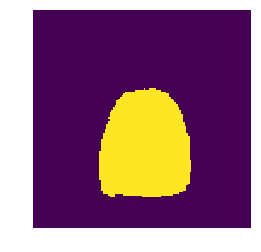

In [ ]:
show_img(py[0]>0);

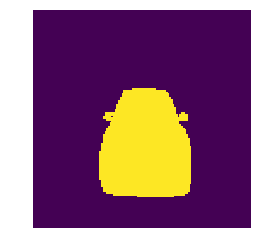

In [ ]:
show_img(y[0]);

## U-net (ish)

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [ ]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [ ]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [ ]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [ ]:
learn.freeze_to(1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|                                                                                           | 0/64 [00:00<?, ?it/s]


Exception in thread Thread-14:
Traceback (most recent call last):
  File "C:\Users\j\Anaconda3\envs\fastai\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\j\Anaconda3\envs\fastai\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\j\Anaconda3\envs\fastai\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 92%|█████████████████████████████████████████████████████████████████▍     | 59/64 [00:22<00:01,  2.68it/s, loss=2.45]


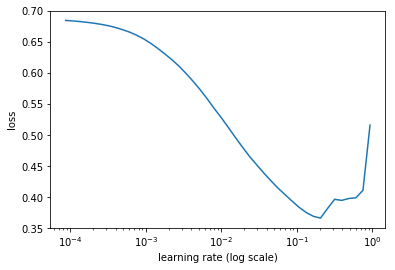

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.12936    0.03934    0.988571   0.971385  
    1      0.098401   0.039252   0.990438   0.974921        
    2      0.087789   0.02539    0.990961   0.978927        
    3      0.082625   0.027984   0.988483   0.975948        
    4      0.079509   0.025003   0.99171    0.981221        
    5      0.076984   0.022514   0.992462   0.981881        
    6      0.076822   0.023203   0.992484   0.982321        
    7      0.075488   0.021956   0.992327   0.982704        



[0.021955982234979434, 0.9923273126284281, 0.9827044502137199]

In [ ]:
learn.save('128urn-tmp')

In [ ]:
learn.load('128urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

  0%|          | 0/64 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.073786   0.023418   0.99297    0.98283   
    1      0.073561   0.020853   0.992142   0.982725        
    2      0.075227   0.023357   0.991076   0.980879        
    3      0.074245   0.02352    0.993108   0.983659        
    4      0.073434   0.021508   0.993024   0.983609        
    5      0.073092   0.020956   0.993188   0.983333        
    6      0.073617   0.019666   0.993035   0.984102        
    7      0.072786   0.019844   0.993196   0.98435         
    8      0.072256   0.018479   0.993282   0.984277        
    9      0.072052   0.019479   0.993164   0.984147        
    10     0.071361   0.019402   0.993344   0.984541        
    11     0.070969   0.018904   0.993139   0.984499        
    12     0.071588   0.018027   0.9935     0.984543        
    13     0.070709   0.018345   0.993491   0.98489         
    14     0.072238   0.019096   0.993594   0.984825

[0.018336569653853538, 0.9936137114252362, 0.9852004420189631]

In [ ]:
learn.save('128urn-0')

In [ ]:
learn.load('128urn-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

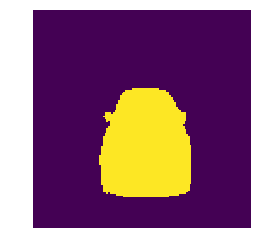

In [ ]:
show_img(py[0]>0);

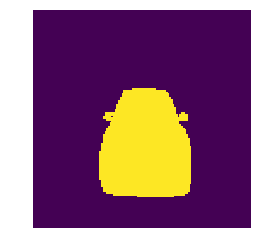

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 512x512

In [ ]:
sz=512
bs=16

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.load('128urn-0')

In [ ]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.071421   0.02362    0.996459   0.991772  
    1      0.070373   0.014013   0.996558   0.992602          
    2      0.067895   0.011482   0.996705   0.992883          
    3      0.070653   0.014256   0.996695   0.992771          
    4      0.068621   0.013195   0.996993   0.993359          



[0.013194938530288046, 0.996993034604996, 0.993358936574724]

In [ ]:
learn.save('512urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.load('512urn-tmp')

In [ ]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice              
    0      0.06605    0.013602   0.997      0.993014  
    1      0.066885   0.011252   0.997248   0.993563          
    2      0.065796   0.009802   0.997223   0.993817          
    3      0.065089   0.009668   0.997296   0.993744          
    4      0.064552   0.011683   0.997269   0.993835          
    5      0.065089   0.010553   0.997415   0.993827          
    6      0.064303   0.009472   0.997431   0.994046          
    7      0.062506   0.009623   0.997441   0.994118          



[0.009623114736602894, 0.9974409020136273, 0.9941179137381296]

In [ ]:
learn.save('512urn')

In [ ]:
learn.load('512urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

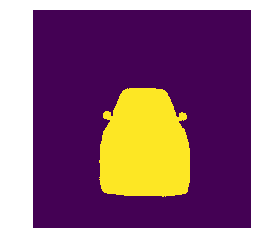

In [ ]:
show_img(py[0]>0);

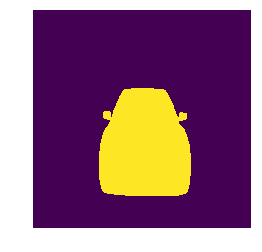

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 1024x1024

In [ ]:
sz=1024
bs=4

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.load('512urn')

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.007656   0.008155   0.997247   0.99353   
    1      0.004706   0.00509    0.998039   0.995437             



[0.005090427414942828, 0.9980387706605215, 0.995437301104031]

In [ ]:
learn.save('1024urn-tmp')

In [ ]:
learn.load('1024urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/200,lr/30,lr])

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.005688   0.006135   0.997616   0.994616  
    1      0.004412   0.005223   0.997983   0.995349             
    2      0.004186   0.004975   0.99806    0.99554              
    3      0.004016   0.004899   0.99812    0.995627             



[0.004898778487196458, 0.9981196409180051, 0.9956271404784823]

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004169   0.004962   0.998049   0.995517  
    1      0.004022   0.004595   0.99823    0.995818             
    2      0.003772   0.004497   0.998215   0.995916             
    3      0.003618   0.004435   0.998291   0.995991             



[0.004434524739663753, 0.9982911745707194, 0.9959913929776539]

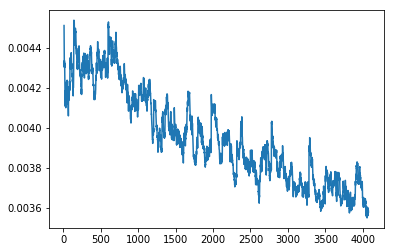

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('1024urn')

In [ ]:
learn.load('1024urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

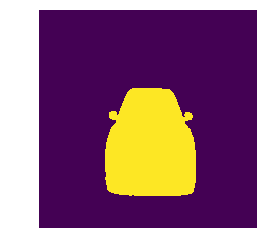

In [ ]:
show_img(py[0]>0);

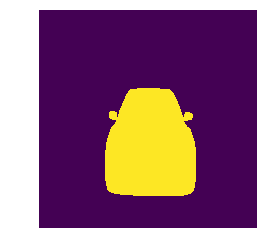

In [ ]:
show_img(y[0]);